In [1]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

In [2]:
import os
from load_image import load_img

img_dir = '/Users/rudra_sarkar/Documents/Mtech Second Sem/Deep Learning/NST/picasso'
dir_images = [os.path.join(img_dir, fname) for fname in os.listdir(img_dir)]
train_images = [np.array(load_img(fname)).reshape(512, 512, 3) for fname in dir_images]

train_images = np.array(train_images)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-05-29 22:46:39.454165: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-29 22:46:39.454915: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
from tensorflow import keras
from keras.datasets import mnist


# (X_train, _), (X_val, _) = mnist.load_data()


In [4]:
# def preprocess_images(images):
#     images = images.reshape((images.shape[0], 512, 512, 3)) / 255
#     return np.where(images > 0.5, 1.0, 0.0 ).astype('float32')

# X_train = preprocess_images(train_images)
# X_val = preprocess_images(X_val)

In [5]:
X_train = train_images

In [6]:
train_size = 3
batch_size = 3
test_size = 10000

train_dataset = (tf.data.Dataset.from_tensor_slices(X_train).shuffle(train_size).batch(batch_size))
# val_dataset = (tf.data.Dataset.from_tensor_slices(X_val).shuffle(test_size).batch(batch_size))

In [7]:
from keras.models import Model
from keras import Sequential, layers

class CVAE(Model):
    """Convulational variational autoencoder"""
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Sequential([
            layers.InputLayer(input_shape = (512, 512, 3)),
            layers.Conv2D(32, 3, strides = (2,2), activation = 'relu'),
            layers.Conv2D(64, 3, strides = (2,2), activation = 'relu'),
            layers.Flatten(),
            layers.Dense(latent_dim + latent_dim)
        ])
        self.decoder = Sequential([
            layers.InputLayer(input_shape = (latent_dim,)),
            layers.Dense(units = 128*128*128, activation = 'relu'),
            layers.Reshape(target_shape = (128,128,128)),
            layers.Conv2DTranspose(64, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu'),
            layers.Conv2DTranspose(32, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu'), 
            layers.Conv2DTranspose(3, kernel_size = 3, strides = 1, padding = 'same')
        ])
    
    @tf.function

    def sample(self, eps = None):
        if eps is None:
            eps = tf.random.normal(shape = (100, self.latent_dim))
        return self.decode(eps, apply_sigmoid = True)

    def encode(self,x):
        mean, log_var = tf.split(self.encoder(x), num_or_size_splits = 2, axis = 1)
        return mean, log_var

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape = (mean.shape))
        return eps * tf.exp(logvar * 0.5) + mean 
        
    def decode(self, z, apply_sigmoid = False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [8]:
optimizer = keras.optimizers.legacy.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis = 1):
    log2pi = tf.math.log(2. * np.pi)
    return  tf.reduce_sum(-5.*((sample - mean)**2. * tf.exp(-logvar) + logvar + log2pi), axis = raxis)

def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits = x_logit, labels = x)
    logpx_z = -tf.reduce_sum(cross_ent, axis = [1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [9]:
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 128
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [10]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [11]:
# assert batch_size >= num_examples_to_generate
for test_batch in train_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 1, Test set ELBO: -582434.3125, time elapse for current epoch: 3.325719118118286


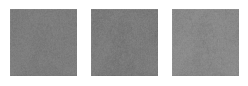

In [12]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in train_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)